# Data Science Salaries for Core Roles (Code and supplementary graphics)

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: 
## (1) live in the USA, 
## (2) share their salary details, and
## (3) are employed as Data Scientists or Data Analysts

In [2]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]

df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

# 2 & 3
df = df.dropna(subset=['Salary'])

df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]

df = df[(df.Occupation=="Data Scientist") | 
        (df.Occupation=="Data Analyst")]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 11 to 23652
Data columns (total 8 columns):
Gender        1098 non-null object
Age           1098 non-null object
Education     1098 non-null object
Major         1097 non-null object
Occupation    1098 non-null object
Industry      1098 non-null object
Experience    1098 non-null object
Salary        1098 non-null object
dtypes: object(8)
memory usage: 77.2+ KB


# There was 1 individual with a missing Major.
## They were dropped.

In [3]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 11 to 23652
Data columns (total 8 columns):
Gender        1097 non-null object
Age           1097 non-null object
Education     1097 non-null object
Major         1097 non-null object
Occupation    1097 non-null object
Industry      1097 non-null object
Experience    1097 non-null object
Salary        1097 non-null object
dtypes: object(8)
memory usage: 77.1+ KB


# Adding Salary, Age, and Experience continuous features for a linear regression model

In [4]:
#Salary
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Salary_Mid'] = df['Salary'].apply(lambda x: dictionary[x])

#Age
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

#Experience
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Experience_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

# Shortening of some labels

In [5]:
dictionary = {'Male'                    : 'Male',
              'Female'                  : 'Female',
              'Prefer not to say'       : 'Unknown', 
              'Prefer to self-describe' : 'Self-Describe'
             }
df.Gender = df.Gender.apply(lambda x: dictionary[x])

dictionary = {'Master’s degree'                                                  : "Master's", 
              'Bachelor’s degree'                                                : "Bachelor's",
              'Some college/university study without earning a bachelor’s degree': 'No Degree',
              'Doctoral degree'                                                  : 'Doctoral', 
              'Professional degree'                                              : 'Professional', 
              'I prefer not to answer'                                           : 'Unknown'
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Art',
              'Information technology, networking, or system administration'  : 'IT',
              'Environmental science or geology'                              : 'Envir Sci', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Humanities',
              'I never declared a major'                                      : "No Major"
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Communication",
              'Academics/Education'                    : "Education", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Non-Profit",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Transport", 
              'Energy/Mining'                          : "Energy", 
              'Retail/Sales'                           : "Sales" ,
              'Military/Security/Defense'              : "Military",
              'Online Business/Internet-based Sales'   : "Online_Sales",
              'Manufacturing/Fabrication'              : "Manufacturing", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Entertainment"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])

# Reordering the columns

In [6]:
df = df[["Occupation","Gender","Education","Major","Industry","Age",
         "Experience","Salary","Age_Mid","Experience_Mid","Salary_Mid"]]

# Count Plots

In [7]:
def pie(column):
    labels = df[column].value_counts().index
    values = df[column].value_counts()
    colors = ['#66b3ff', '#ff9999', '#77dd77', '#fdfd96', '#ff6961', 
              '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', 
              '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', 
              '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',]
    
    marker = dict(colors=colors,line=dict(color='#FFF', width=2))
    font = dict(size=16, color='#7f7f7f')
    layout = go.Layout(height = 700,
                       width = 1000,
                       autosize = False,
                       title = ("Pie Chart of " + column),
                       font = font)

    fig = go.Figure(data=[go.Pie(labels=labels, values=values, 
                                 marker=marker, showlegend=False, 
                                 textinfo='label+percent')], layout=layout)
    fig.show()

for label in df.columns[:8]:
    pie(label)

# User-Defined Functions

In [8]:
def sorted_by_mean(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for 
                        col, vals in 
                        df.groupby(by)}).mean().sort_values(ascending=False)
    return df2.index

def ttest(df,occupation,feature,a,b):
    # example: ttest(df,"Data Scientist","Education","Bachelor's","Doctoral")  
    low_df = df[df[feature] == a]
    high_df = df[df[feature] == b]
    t,p = stats.ttest_ind(low_df.Salary_Mid[low_df["Occupation"] == occupation],
                          high_df.Salary_Mid[high_df["Occupation"] == occupation], equal_var = False)
    print(occupation + "'s", a, "vs", b, "p-value:", "{:.3f}".format(p))

def genttest(df,industry):
    m_df = df[df["Gender"] == "Male"]
    f_df = df[df["Gender"] == "Female"]
    t,p = stats.ttest_ind(m_df.Salary_Mid[m_df["Industry"] == industry],
                          f_df.Salary_Mid[f_df["Industry"] == industry], equal_var = False)
    print(industry + "'s", "Male vs Female p-value:", "{:.3f}".format(p))

#DSA stands for Data Scientists and Data Analysts
def DSA(df, column, order, palette):
    if palette == "Blues_r":
        title = "(Averaged Salaries)"
        
    if palette == "Greens_r":
        title = "(Salary > Median)"
        
    if palette == "Reds_r":
        title = "(Salary <= Median)"
        
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize = (20, 12))
    mpl.rcParams['font.size'] = 30

    sns.boxplot(x = df["Salary_Mid"], y = df[column],
                hue = df["Occupation"], hue_order = ["Data Scientist","Data Analyst"],
                linewidth = 4, 
                palette = palette, order = order)

    plt.xlim(0,400000)
    plt.title(column + " vs Salary " + title)
    if palette == "Blues_r":
        plt.axvline(112500, color = 'r', linestyle = '-')
    plt.legend(loc = "upper right")
    return plt.show()

#Gen stands for Gender; for exploring if Simpson's Paradox is occurring
def Gen(df, column, order, palette):
    if palette == darkgen:
        title = "(Averaged Salaries for Data Scientists)"

    if palette == lightgen:
        title = "(Averaged Salaries for Data Analysts)"
        
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize = (20, 12))
    mpl.rcParams['font.size'] = 30

    sns.boxplot(x = df["Salary_Mid"], y = df[column],
                hue = df["Gender"], hue_order = ["Male","Female"],
                linewidth = 4,
                palette = palette, order = order)

    plt.xlim(0,400000)
    plt.title(column + " vs Salary " + title)
    plt.legend(loc="upper right")
    return plt.show()

# Variable assignments

In [9]:
top_df = df[df.Salary_Mid>df.Salary_Mid.median()]
btm_df = df[df.Salary_Mid<=df.Salary_Mid.median()]

exp_column="Experience"
exp_order = (['30 +','25-30','20-25','15-20','10-15',
              '5-10','4-5','3-4','2-3','1-2','0-1'])

edu_column="Education"
edu_order = (["Professional","Doctoral","Master's",
              "Bachelor's","No Degree","Unknown"])

gen_column="Gender"
gen_order = (["Male","Female", 
              "Unknown","Self-Describe"])

age_column="Age"
age_order = (['80+', '70-79', '60-69', '55-59',
          '50-54', '45-49', '40-44','35-39',
          '30-34', '25-29','22-24', '18-21'])

maj_column="Major"
maj_order=sorted_by_mean(df, ["Major"], "Salary_Mid")

ind_column="Industry"
ind_order=sorted_by_mean(df, ["Industry"], "Salary_Mid")

# palettes used for gender hues
darkgen = ['#66b3ff','#ff9999']
lightgen = ['#77dd77', '#fdfd96']

# Checking Statistics of Data Scientists and Data Analysts

In [10]:
print("DA")
print(df.Salary_Mid[df.Occupation=="Data Analyst"].median())
print(df.Salary_Mid[df.Occupation=="Data Analyst"].describe())
print("")
print("DS")
print(df.Salary_Mid[df.Occupation=="Data Scientist"].median())
print(df.Salary_Mid[df.Occupation=="Data Scientist"].describe())

DA
75000.0
count       321.000000
mean      76588.785047
std       33551.602962
min        5000.000000
25%       55000.000000
50%       75000.000000
75%       95000.000000
max      275000.000000
Name: Salary_Mid, dtype: float64

DS
112500.0
count       776.000000
mean     125750.644330
std       60406.488646
min        5000.000000
25%       92500.000000
50%      112500.000000
75%      137500.000000
max      500000.000000
Name: Salary_Mid, dtype: float64


# Boxplots and Statistics

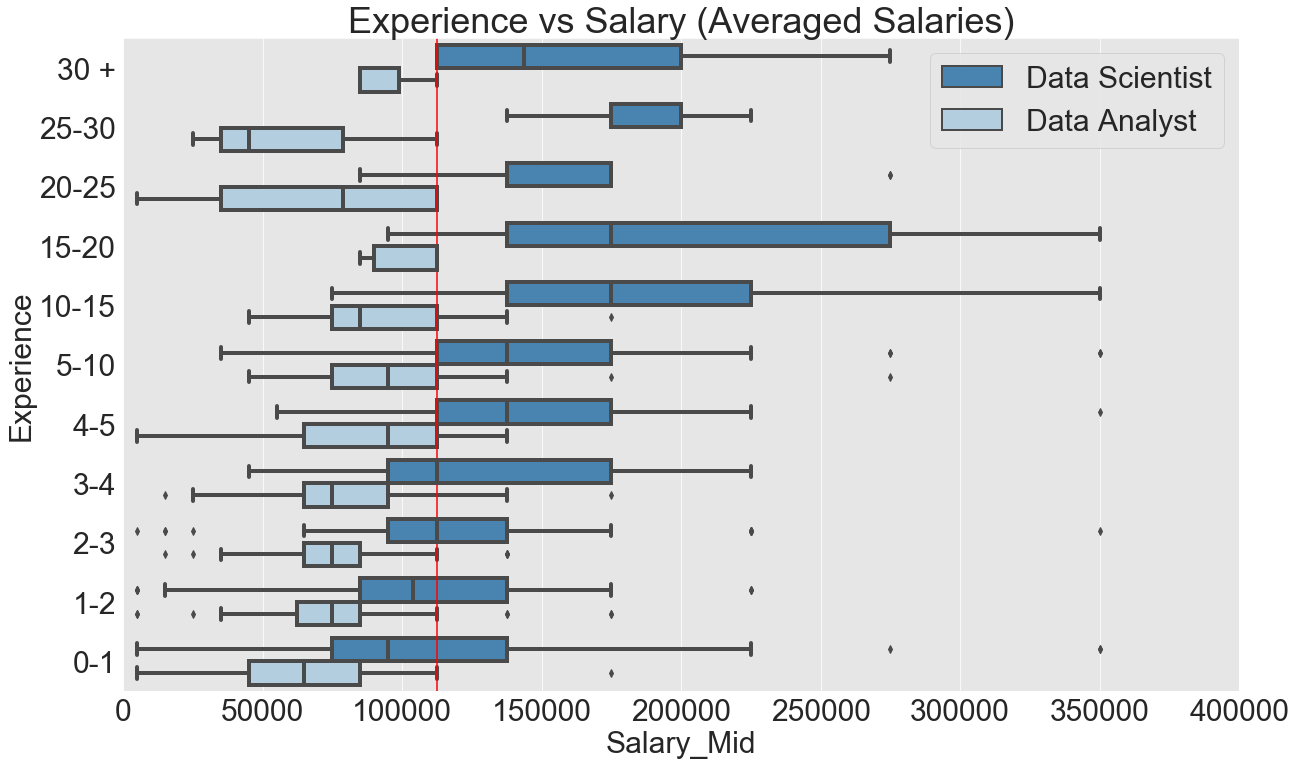

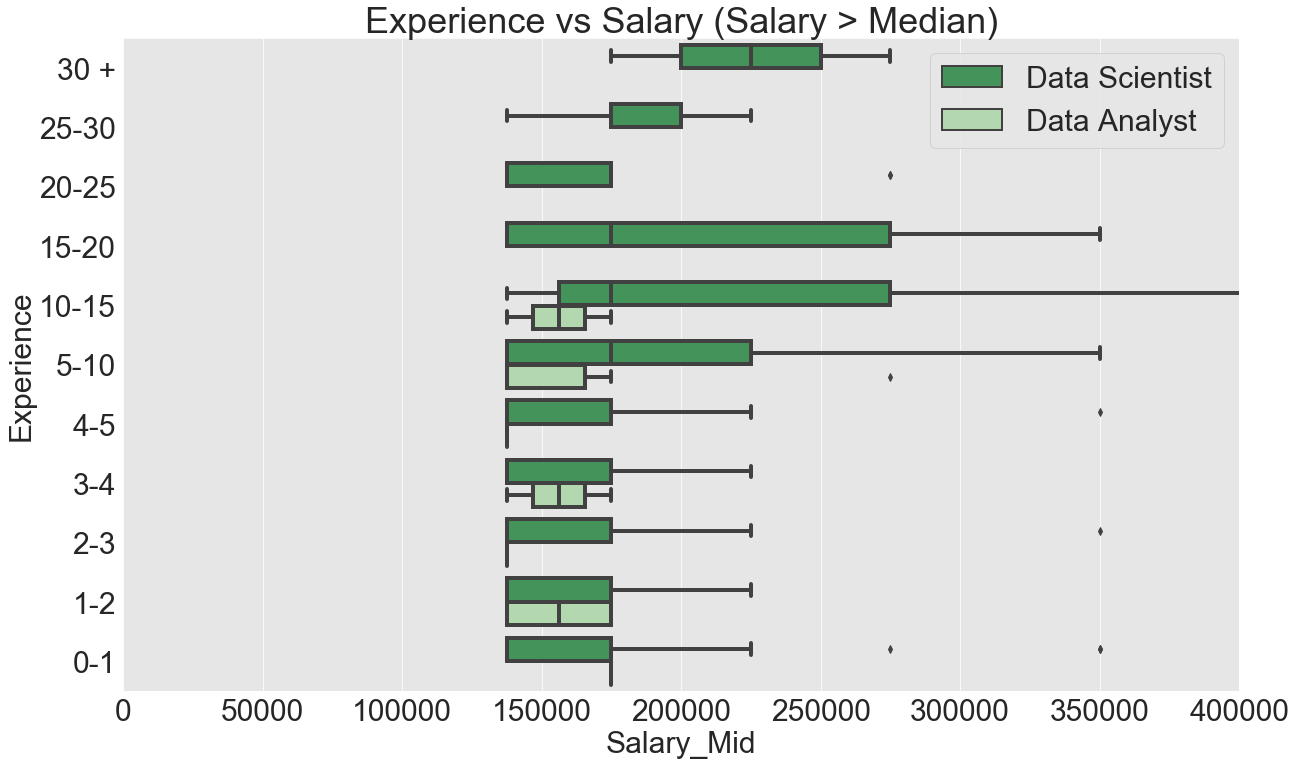

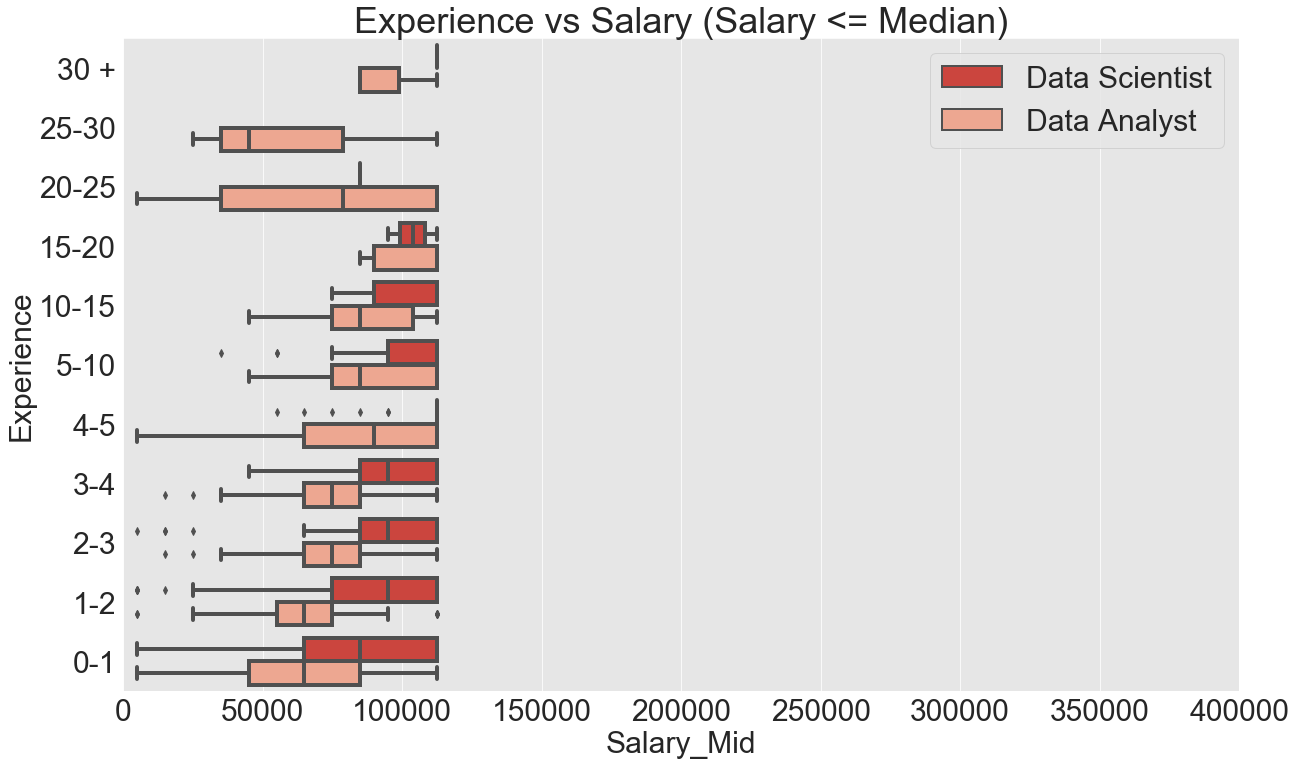

In [11]:
DSA(df, exp_column, exp_order, "Blues_r")
DSA(top_df, exp_column, exp_order, "Greens_r")
DSA(btm_df, exp_column, exp_order, "Reds_r")

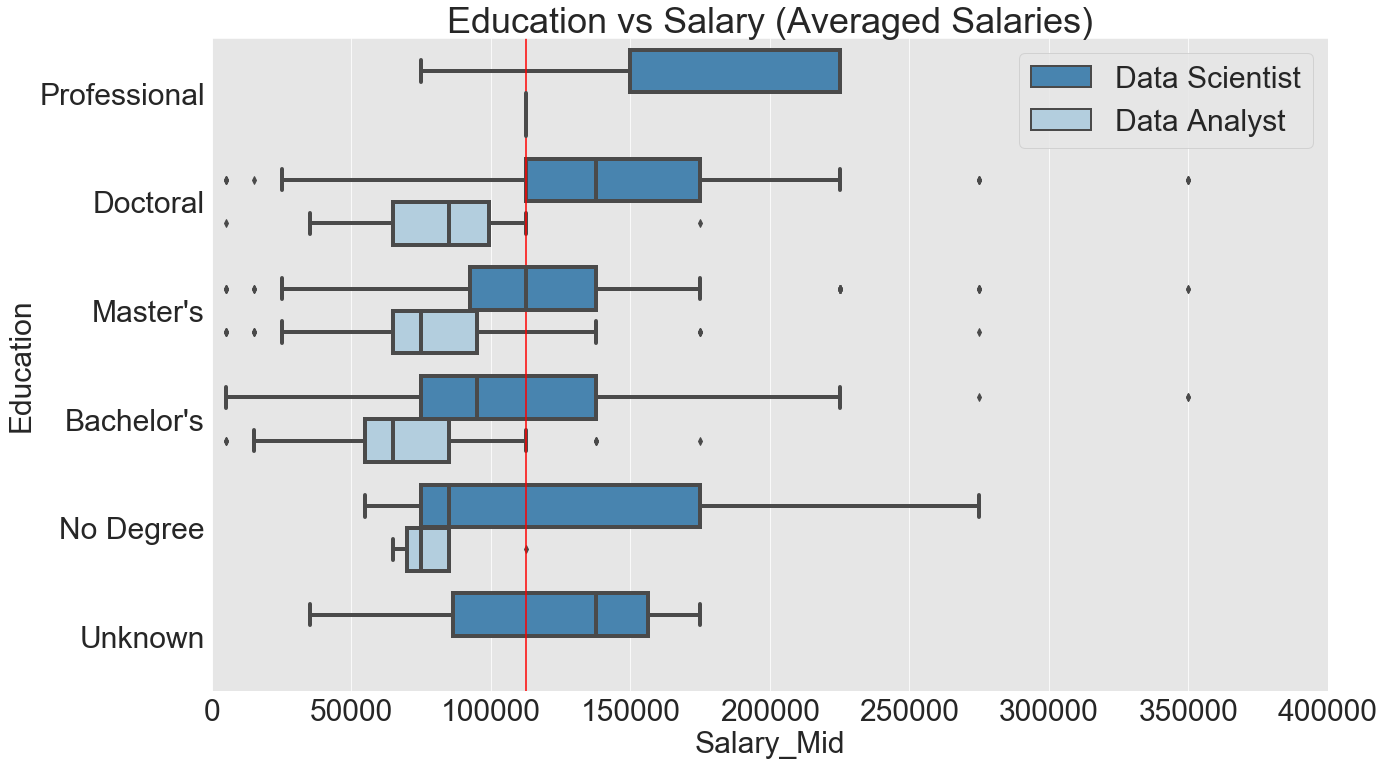

Data Analyst's No Degree vs Bachelor's p-value: 0.207
Data Analyst's Bachelor's vs Master's p-value: 0.050
Data Analyst's Master's vs Doctoral p-value: 0.849
Data Analyst's Bachelor's vs Doctoral p-value: 0.289

Data Scientist's No Degree vs Bachelor's p-value: 0.512
Data Scientist's Bachelor's vs Master's p-value: 0.044
Data Scientist's Master's vs Doctoral p-value: 0.000
Data Scientist's Bachelor's vs Doctoral p-value: 0.000
Data Scientist's Doctoral vs Professional p-value: 0.610


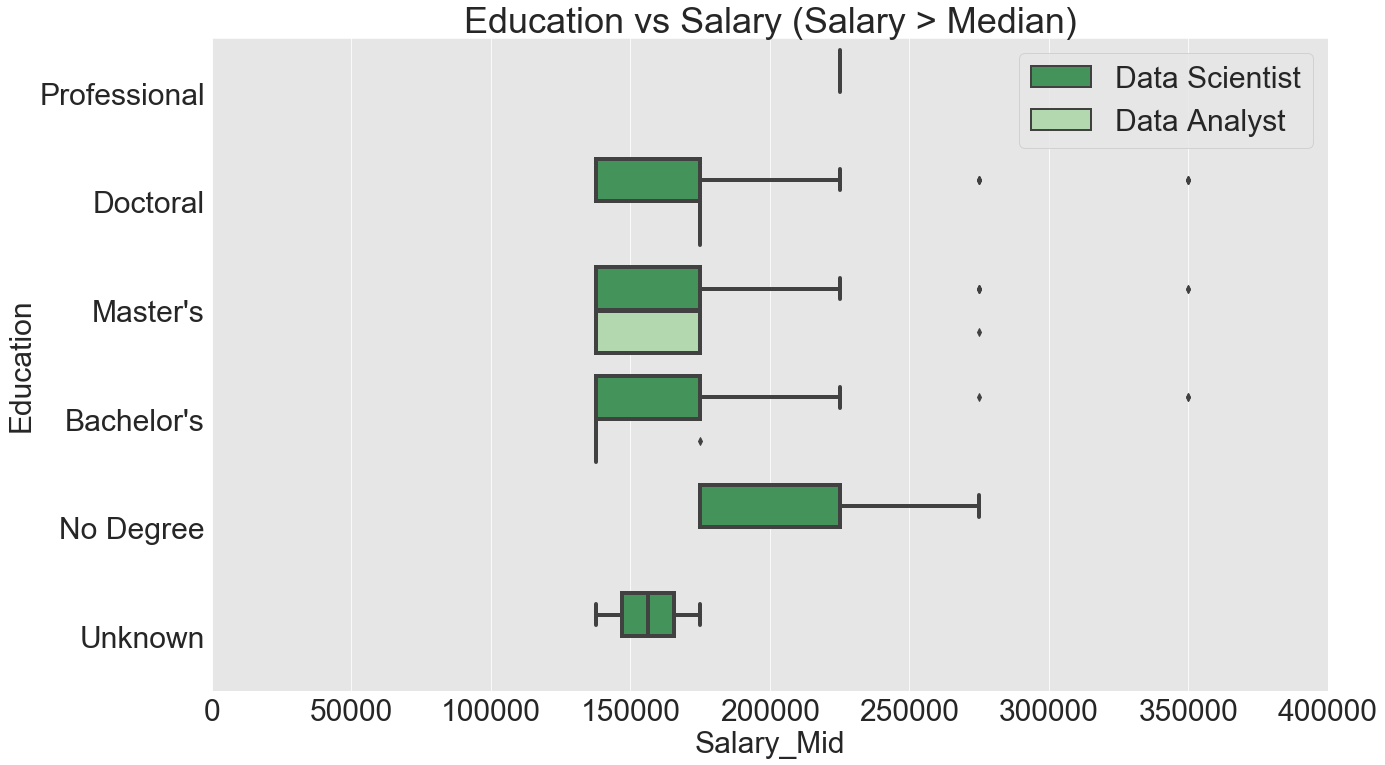

Data Analyst's No Degree vs Bachelor's p-value: nan
Data Analyst's Bachelor's vs Master's p-value: 0.316
Data Analyst's Master's vs Doctoral p-value: nan
Data Analyst's Bachelor's vs Doctoral p-value: nan

Data Scientist's No Degree vs Bachelor's p-value: 0.373
Data Scientist's Bachelor's vs Master's p-value: 0.974
Data Scientist's Master's vs Doctoral p-value: 0.077
Data Scientist's Bachelor's vs Doctoral p-value: 0.201


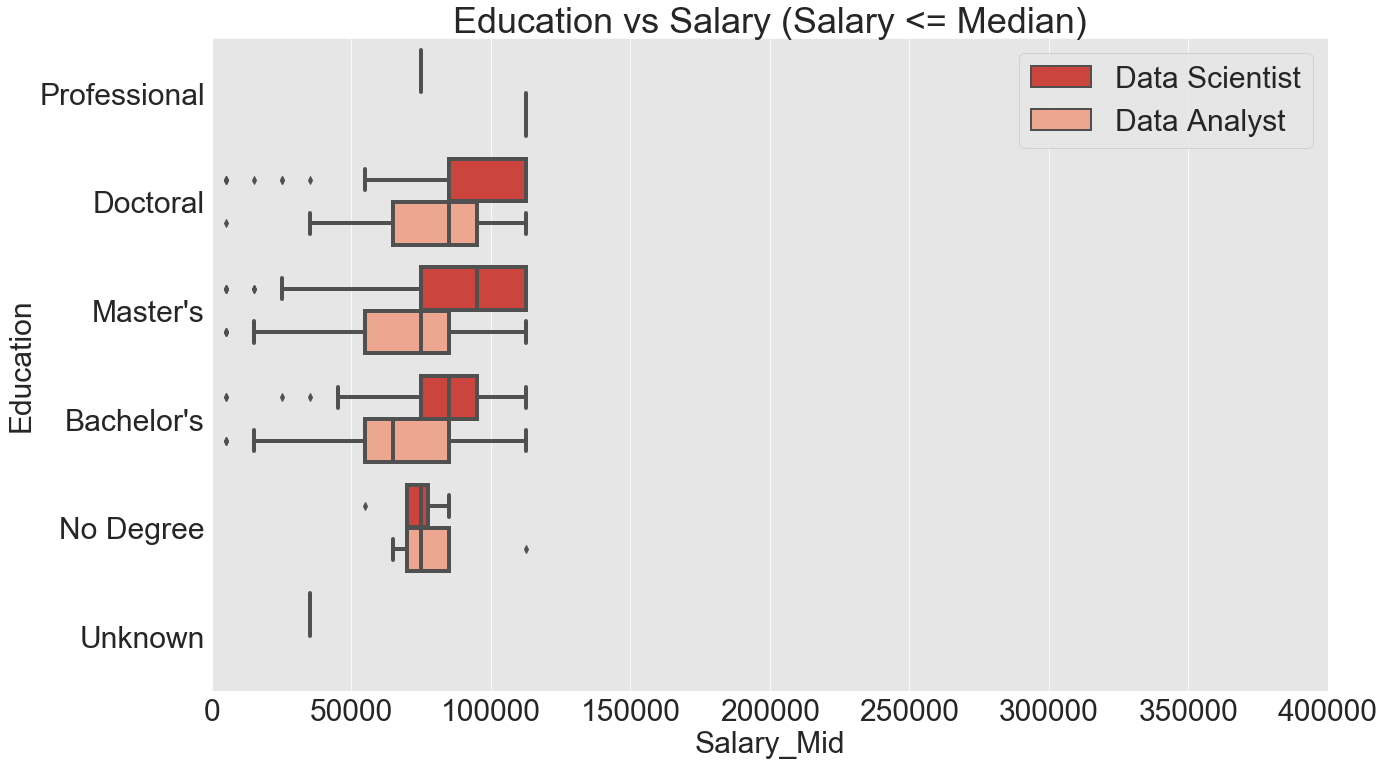

Data Analyst's No Degree vs Bachelor's p-value: 0.084
Data Analyst's Bachelor's vs Master's p-value: 0.106
Data Analyst's Master's vs Doctoral p-value: 0.685
Data Analyst's Bachelor's vs Doctoral p-value: 0.270

Data Scientist's No Degree vs Bachelor's p-value: 0.260
Data Scientist's Bachelor's vs Master's p-value: 0.003
Data Scientist's Master's vs Doctoral p-value: 0.469
Data Scientist's Bachelor's vs Doctoral p-value: 0.005


In [12]:
DSA(df, edu_column, edu_order, "Blues_r")
ttest(df,"Data Analyst","Education","No Degree","Bachelor's")
ttest(df,"Data Analyst","Education","Bachelor's","Master's")
ttest(df,"Data Analyst","Education","Master's","Doctoral")    
ttest(df,"Data Analyst","Education","Bachelor's","Doctoral")  
print("")
ttest(df,"Data Scientist","Education","No Degree","Bachelor's")
ttest(df,"Data Scientist","Education","Bachelor's","Master's")
ttest(df,"Data Scientist","Education","Master's","Doctoral")    
ttest(df,"Data Scientist","Education","Bachelor's","Doctoral")  
ttest(df,"Data Scientist","Education","Doctoral","Professional")  

DSA(top_df, edu_column, edu_order, "Greens_r")
ttest(top_df,"Data Analyst","Education","No Degree","Bachelor's")
ttest(top_df,"Data Analyst","Education","Bachelor's","Master's")
ttest(top_df,"Data Analyst","Education","Master's","Doctoral")    
ttest(top_df,"Data Analyst","Education","Bachelor's","Doctoral")  
print("")
ttest(top_df,"Data Scientist","Education","No Degree","Bachelor's")
ttest(top_df,"Data Scientist","Education","Bachelor's","Master's")
ttest(top_df,"Data Scientist","Education","Master's","Doctoral")    
ttest(top_df,"Data Scientist","Education","Bachelor's","Doctoral")  


DSA(btm_df, edu_column, edu_order, "Reds_r")
ttest(btm_df,"Data Analyst","Education","No Degree","Bachelor's")
ttest(btm_df,"Data Analyst","Education","Bachelor's","Master's")
ttest(btm_df,"Data Analyst","Education","Master's","Doctoral")    
ttest(btm_df,"Data Analyst","Education","Bachelor's","Doctoral")  
print("")
ttest(btm_df,"Data Scientist","Education","No Degree","Bachelor's")
ttest(btm_df,"Data Scientist","Education","Bachelor's","Master's")
ttest(btm_df,"Data Scientist","Education","Master's","Doctoral")    
ttest(btm_df,"Data Scientist","Education","Bachelor's","Doctoral")  

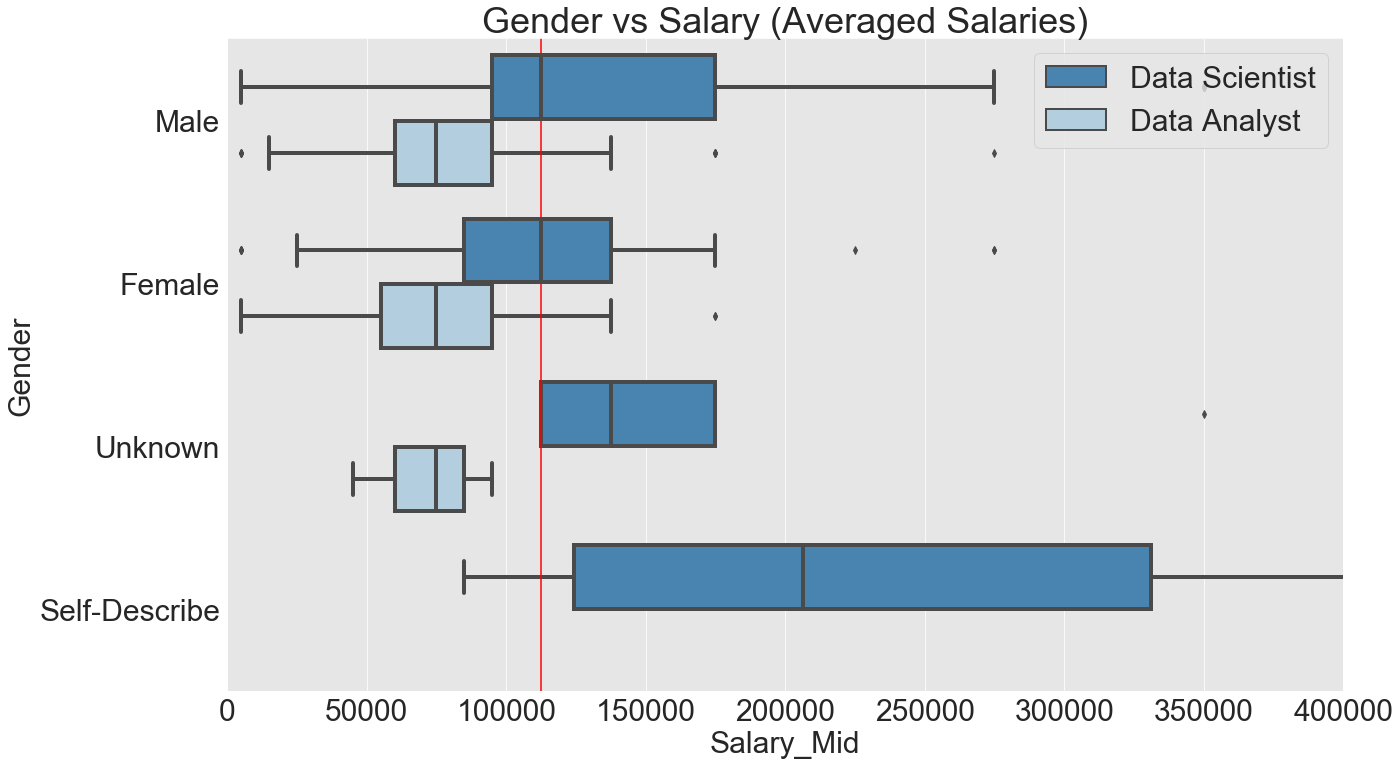

Data Analyst's Male vs Female p-value: 0.574

Data Scientist's Male vs Female p-value: 0.000


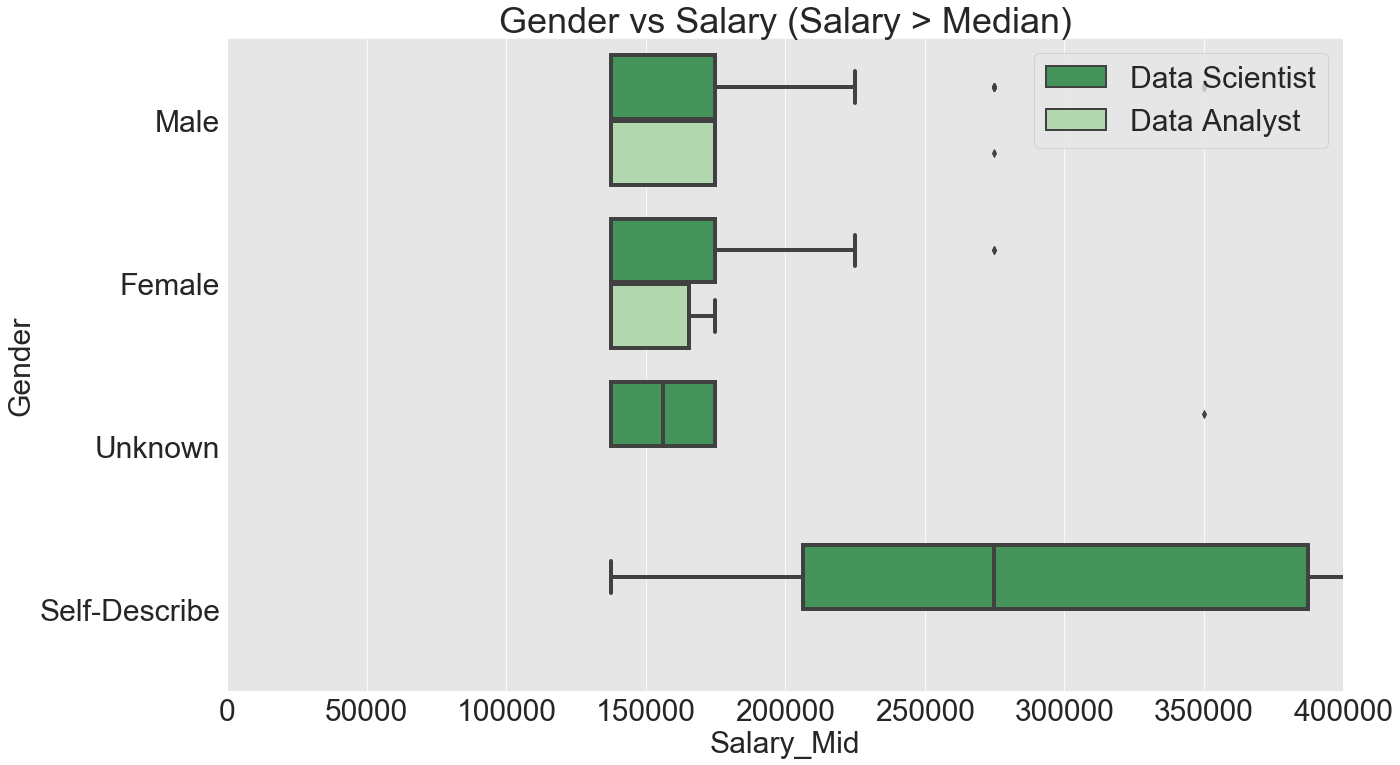

Data Analyst's Male vs Female p-value: 0.540

Data Scientist's Male vs Female p-value: 0.000

Male
          Age_Mid  Experience_Mid     Salary_Mid
count  259.000000      259.000000     259.000000
mean    37.077220        5.976834  179247.104247
std      9.403932        6.411702   57704.076184
min     19.500000        0.500000  137500.000000
25%     32.000000        1.500000  137500.000000
50%     32.000000        3.500000  175000.000000
75%     42.000000        7.500000  175000.000000
max     64.500000       30.000000  450000.000000

Female
         Age_Mid  Experience_Mid     Salary_Mid
count  61.000000       61.000000      61.000000
mean   35.040984        5.180328  154508.196721
std     8.741803        6.737972   29758.821074
min    23.000000        0.500000  137500.000000
25%    27.000000        1.500000  137500.000000
50%    32.000000        2.500000  137500.000000
75%    37.000000        7.500000  175000.000000
max    64.500000       30.000000  275000.000000


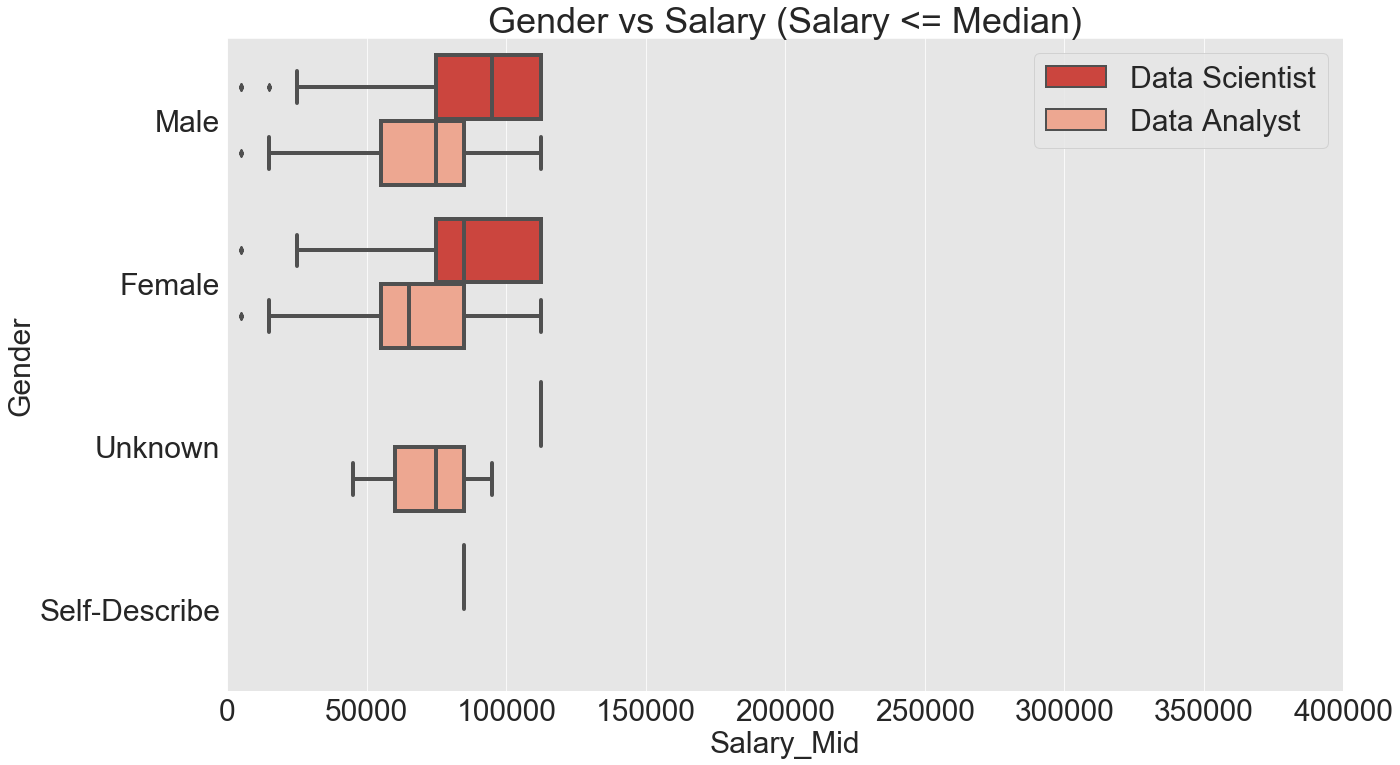

Data Analyst's Male vs Female p-value: 0.444

Data Scientist's Male vs Female p-value: 0.064


In [13]:
DSA(df, gen_column, gen_order, "Blues_r")
ttest(df,"Data Analyst","Gender","Male","Female")
print("")
ttest(df,"Data Scientist","Gender","Male","Female")


DSA(top_df, gen_column, gen_order, "Greens_r")
ttest(top_df,"Data Analyst","Gender","Male","Female")
print("")
ttest(top_df,"Data Scientist","Gender","Male","Female")


print("")
print("Male")
print(top_df[(top_df.Gender=="Male") & (top_df.Occupation=="Data Scientist")].describe())
print("")
print("Female")
print(top_df[(top_df.Gender=="Female") & (top_df.Occupation=="Data Scientist")].describe())


DSA(btm_df, gen_column, gen_order, "Reds_r")
ttest(btm_df,"Data Analyst","Gender","Male","Female")
print("")
ttest(btm_df,"Data Scientist","Gender","Male","Female")

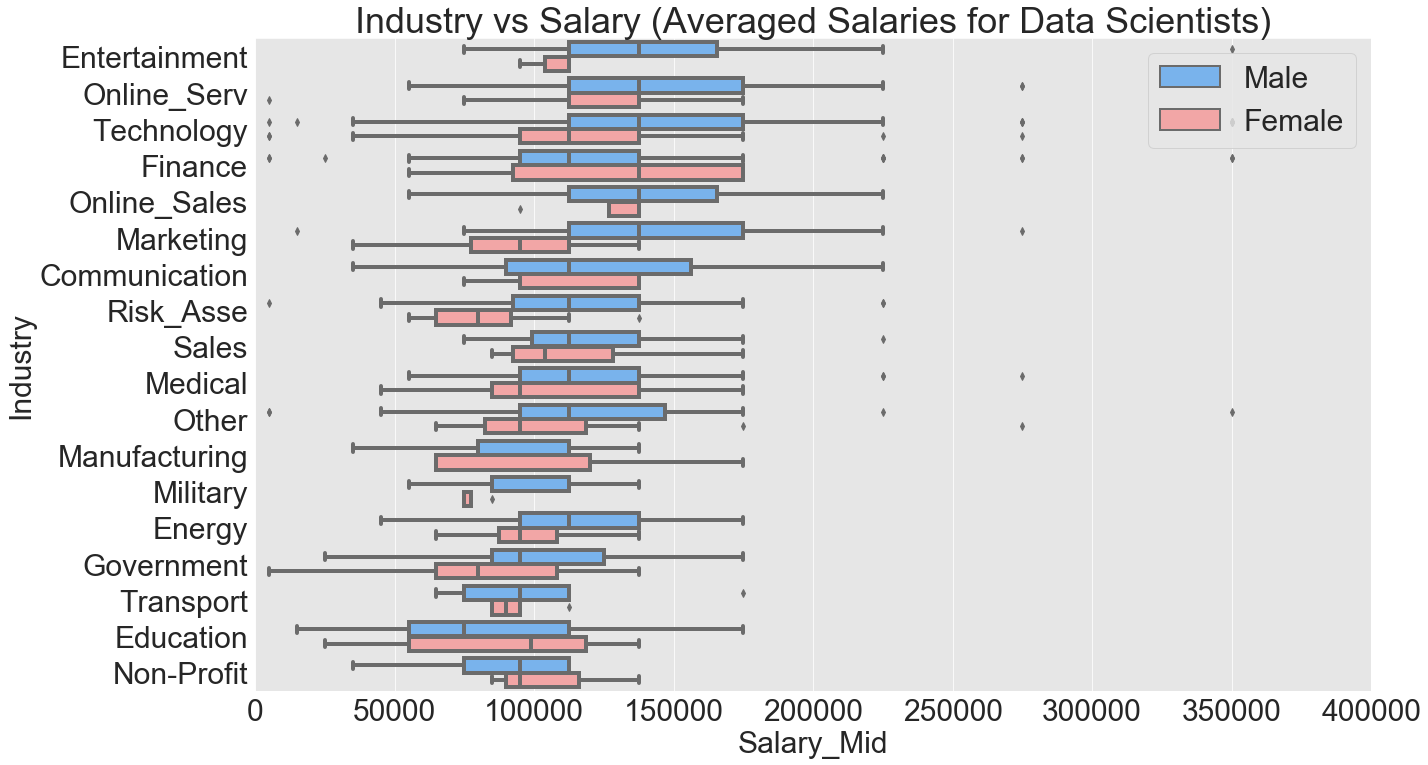

Entertainment's Male vs Female p-value: 0.046
Online_Serv's Male vs Female p-value: 0.045
Technology's Male vs Female p-value: 0.005
Finance's Male vs Female p-value: 0.693
Online_Sales's Male vs Female p-value: 0.672
Marketing's Male vs Female p-value: 0.002
Communication's Male vs Female p-value: 0.751
Risk_Asse's Male vs Female p-value: 0.011
Sales's Male vs Female p-value: 0.865
Medical's Male vs Female p-value: 0.309
Other's Male vs Female p-value: 0.713
Manufacturing's Male vs Female p-value: 0.917
Military's Male vs Female p-value: 0.005
Energy's Male vs Female p-value: 0.269
Government's Male vs Female p-value: 0.121
Transport's Male vs Female p-value: 0.677
Education's Male vs Female p-value: 0.498
Non-Profit's Male vs Female p-value: 0.341


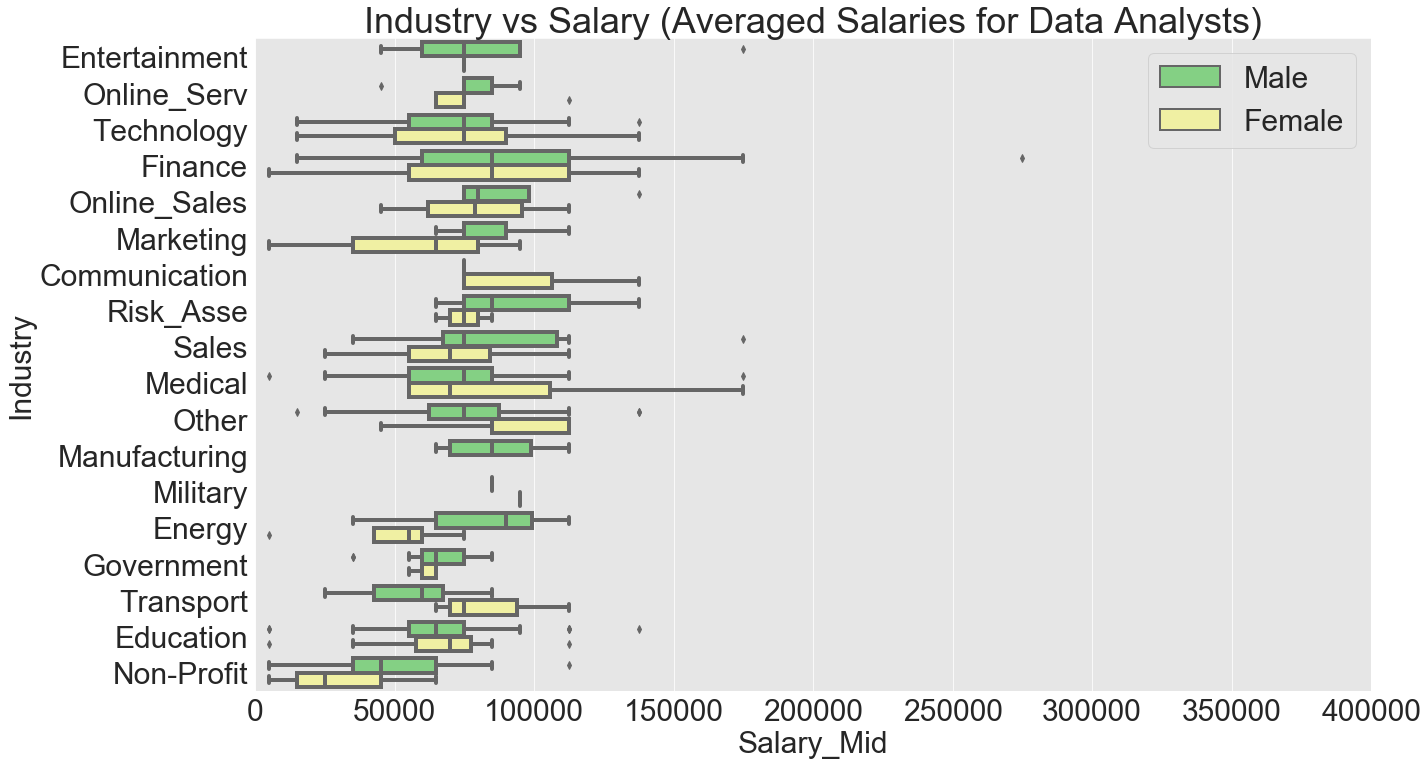

Entertainment's Male vs Female p-value: nan
Online_Serv's Male vs Female p-value: 0.905
Technology's Male vs Female p-value: 0.836
Finance's Male vs Female p-value: 0.532
Online_Sales's Male vs Female p-value: 0.748
Marketing's Male vs Female p-value: 0.403
Communication's Male vs Female p-value: 0.423
Risk_Asse's Male vs Female p-value: 0.278
Sales's Male vs Female p-value: 0.438
Medical's Male vs Female p-value: 0.351
Other's Male vs Female p-value: 0.445
Manufacturing's Male vs Female p-value: nan
Military's Male vs Female p-value: nan
Energy's Male vs Female p-value: 0.083
Government's Male vs Female p-value: 0.700
Transport's Male vs Female p-value: 0.181
Education's Male vs Female p-value: 0.792
Non-Profit's Male vs Female p-value: 0.399


In [14]:
dsdf = df[df.Occupation=="Data Scientist"]
dadf = df[df.Occupation=="Data Analyst"]

Gen(dsdf, ind_column, ind_order, darkgen)
for x in ind_order:
    genttest(dsdf,x)

Gen(dadf, ind_column, ind_order, lightgen)
for x in ind_order:
    genttest(dadf,x)

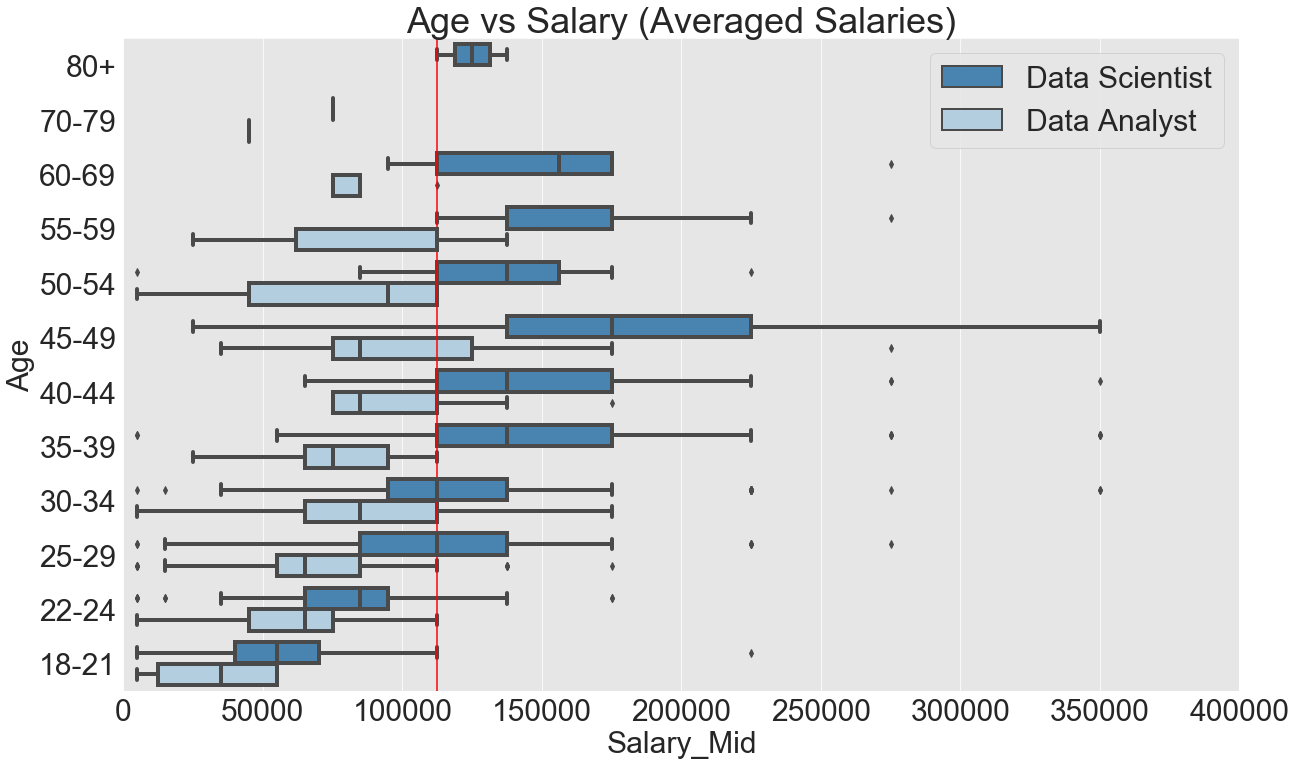

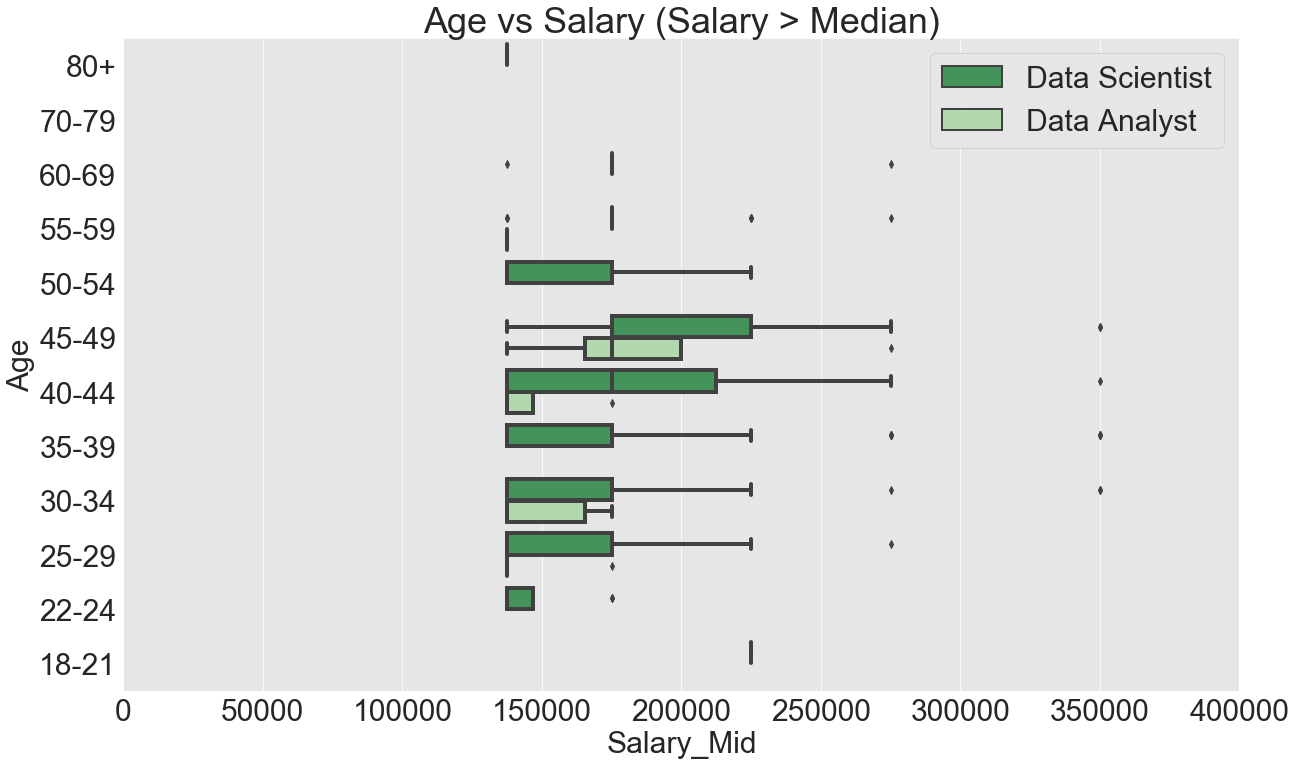

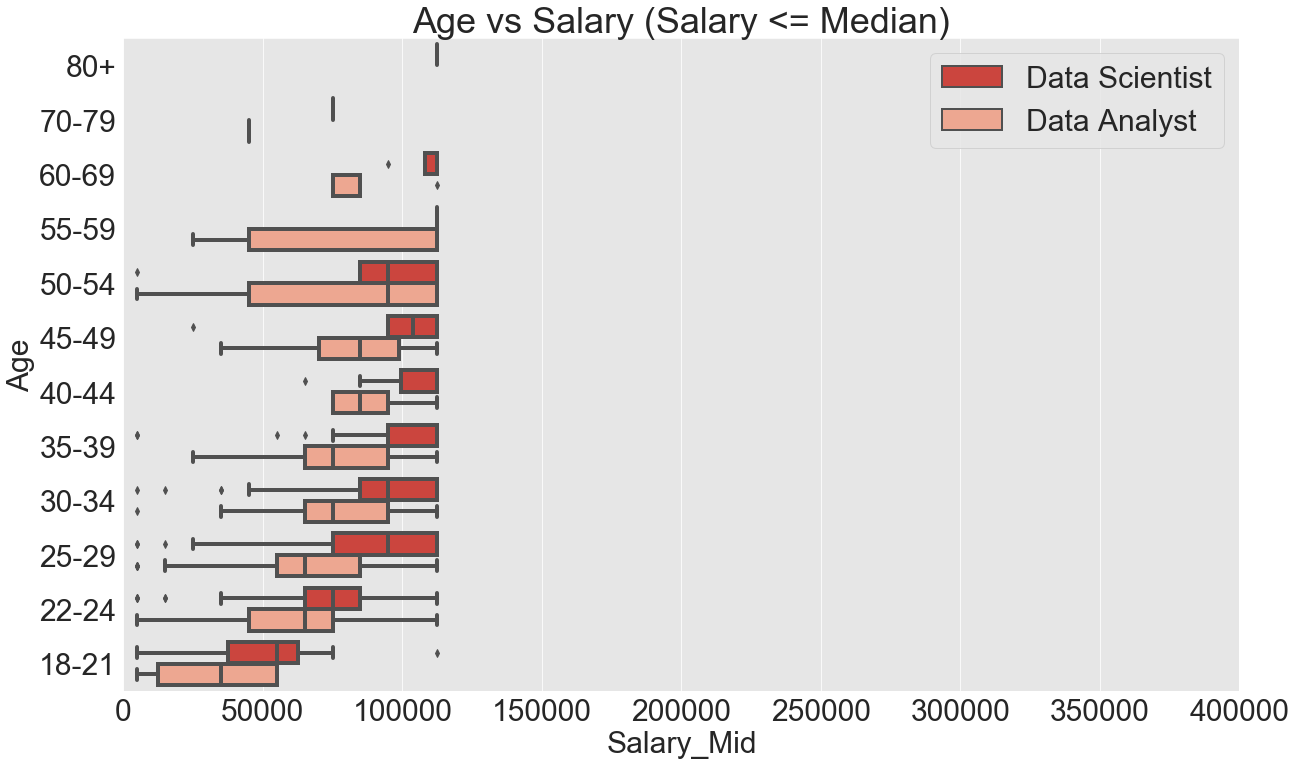

In [15]:
DSA(df, age_column, age_order, "Blues_r")
DSA(top_df, age_column, age_order, "Greens_r")
DSA(btm_df, age_column, age_order, "Reds_r")

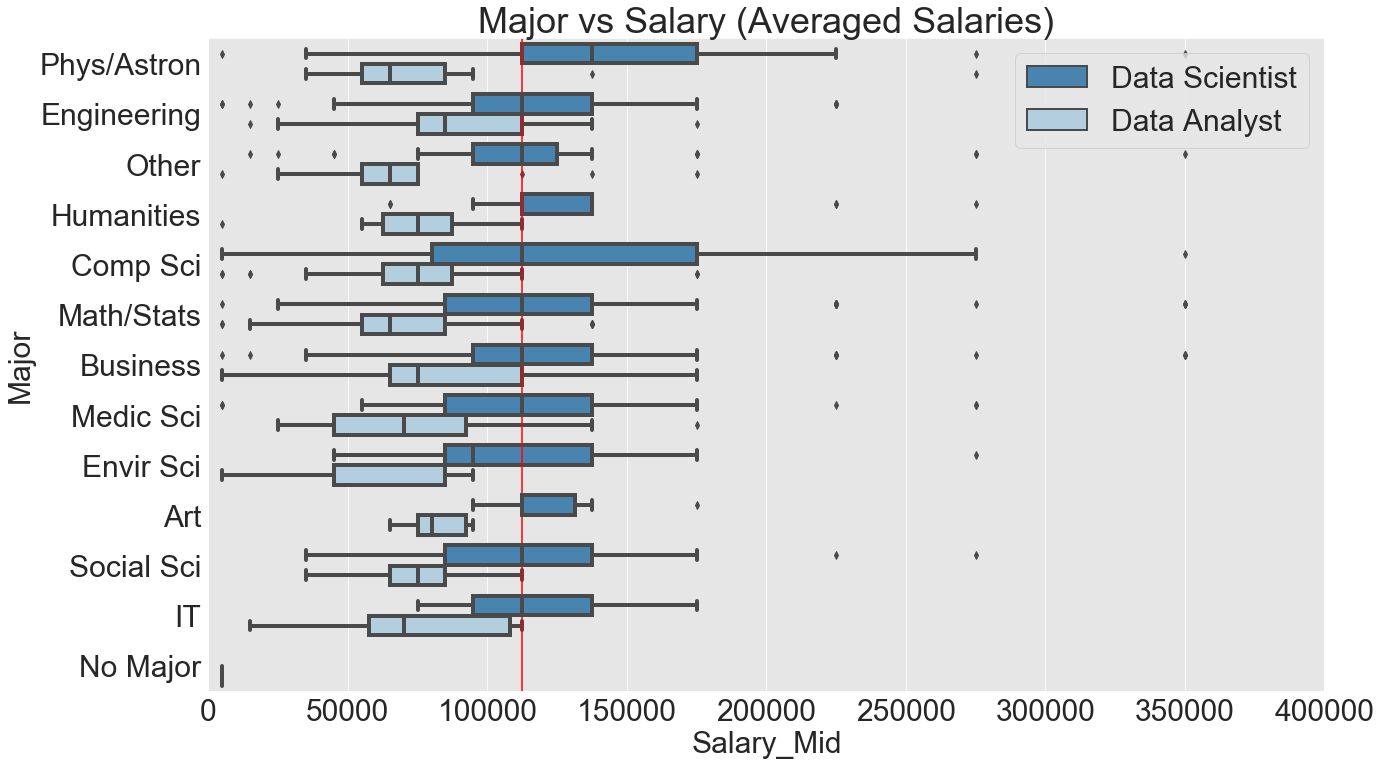

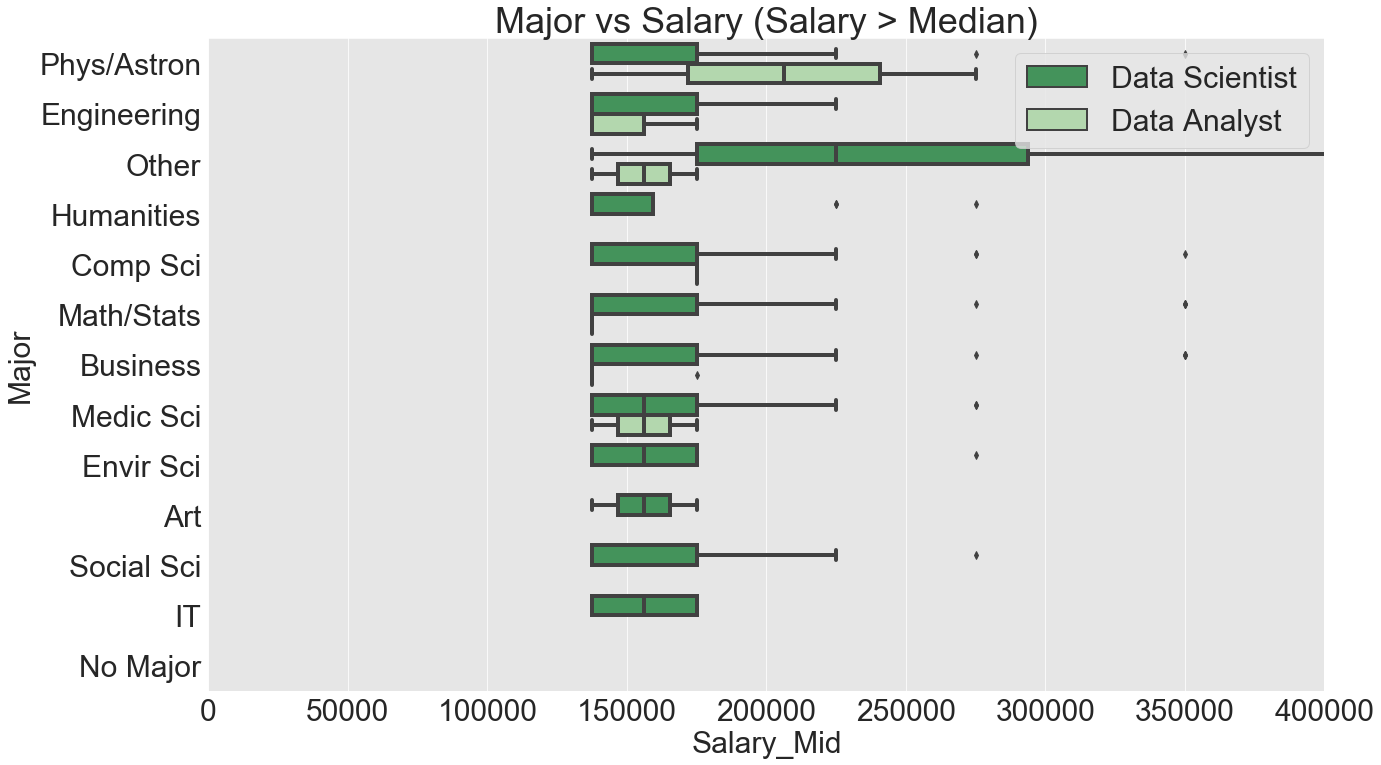

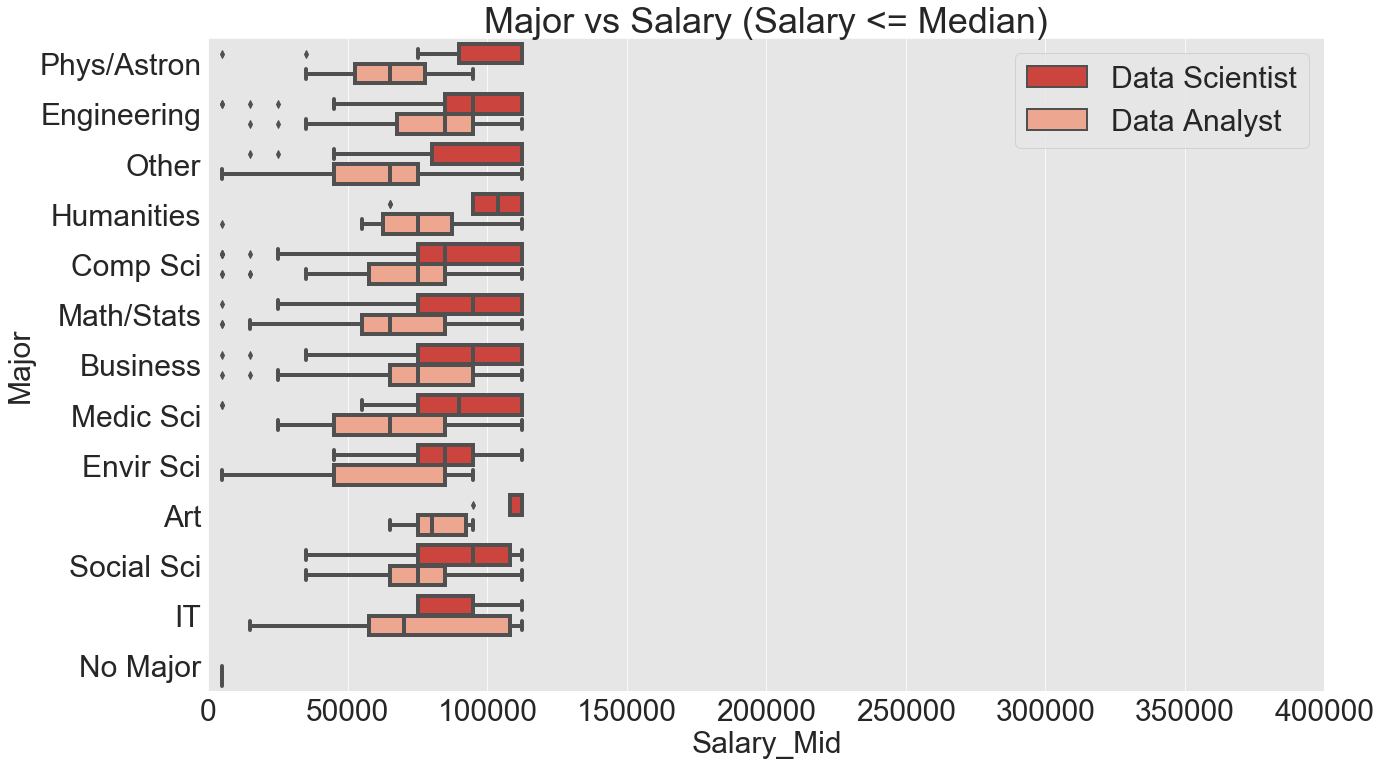

In [16]:
DSA(df, maj_column, maj_order, "Blues_r")
DSA(top_df, maj_column, maj_order, "Greens_r")
DSA(btm_df, maj_column, maj_order, "Reds_r")

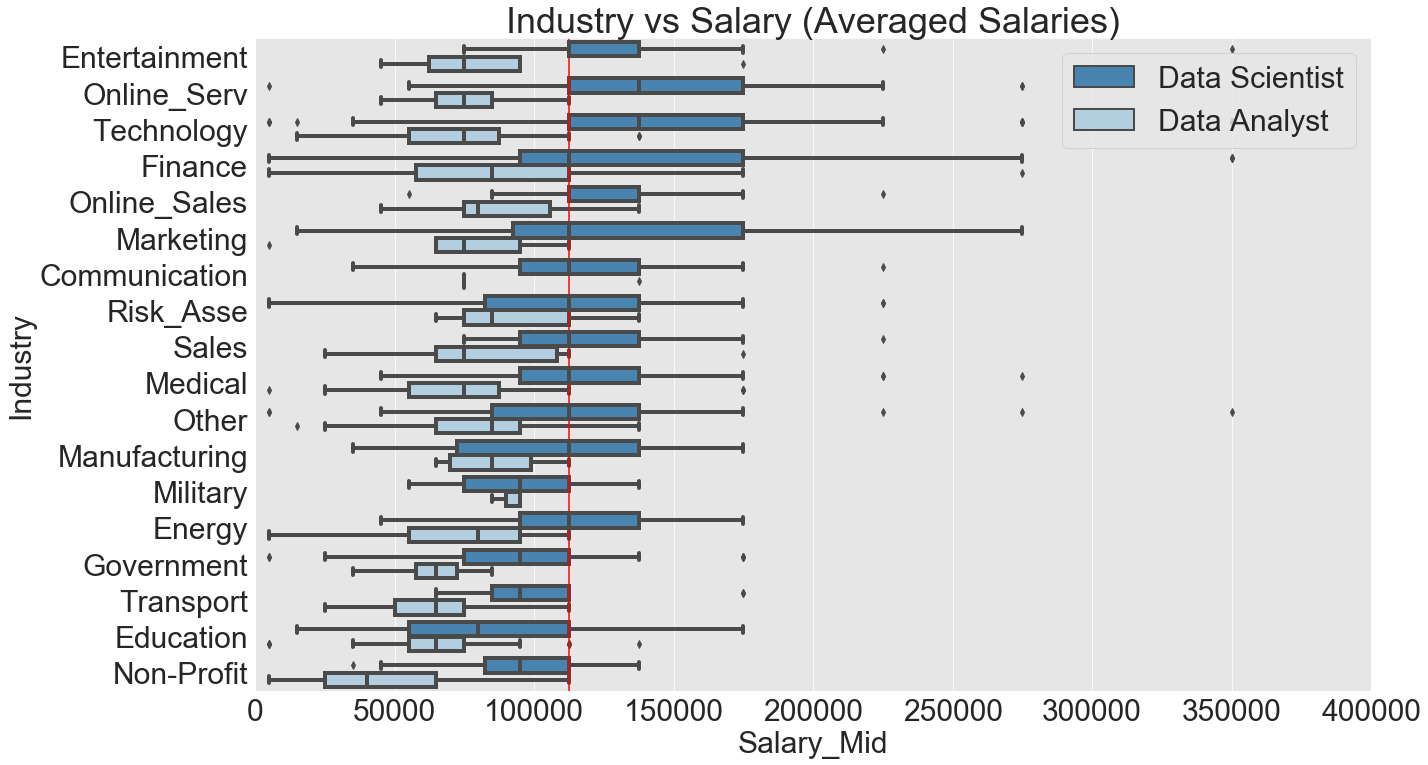

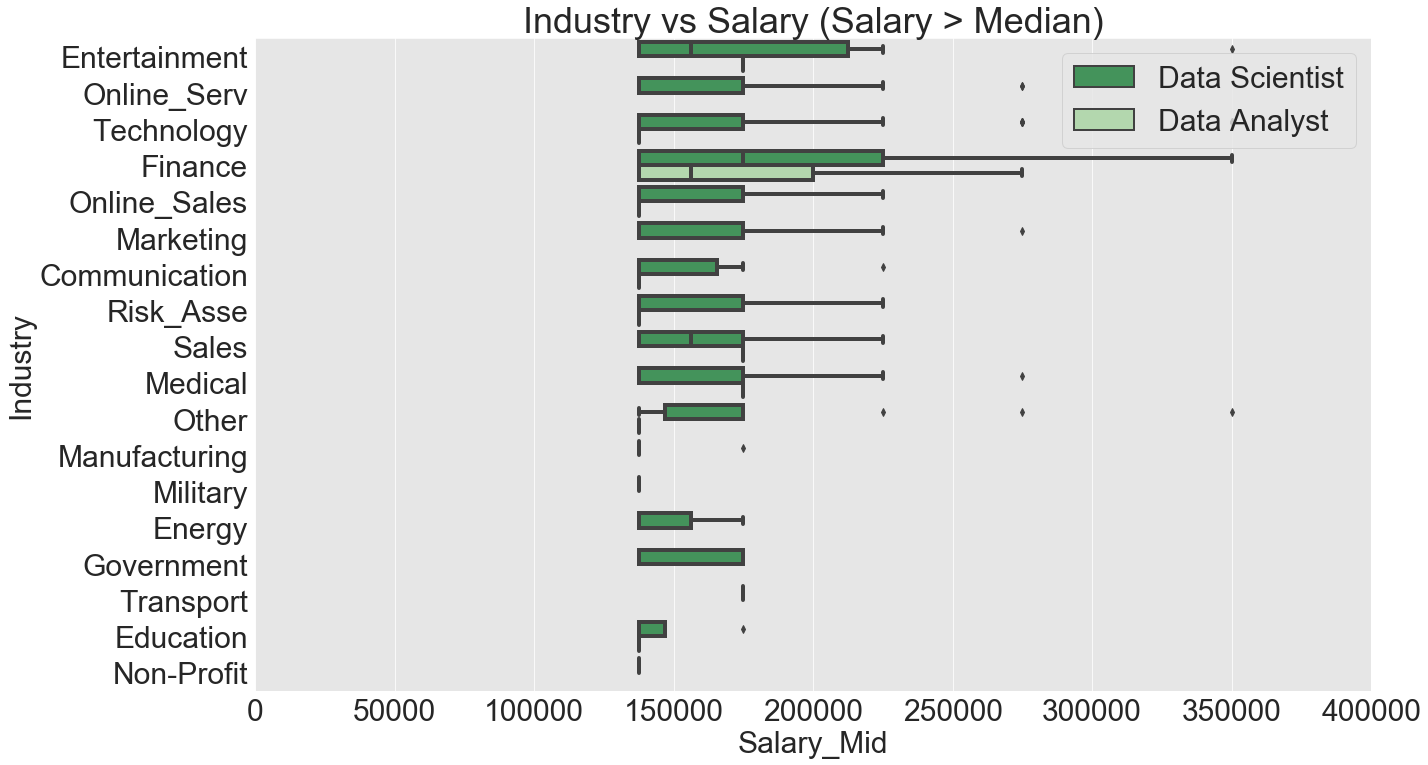

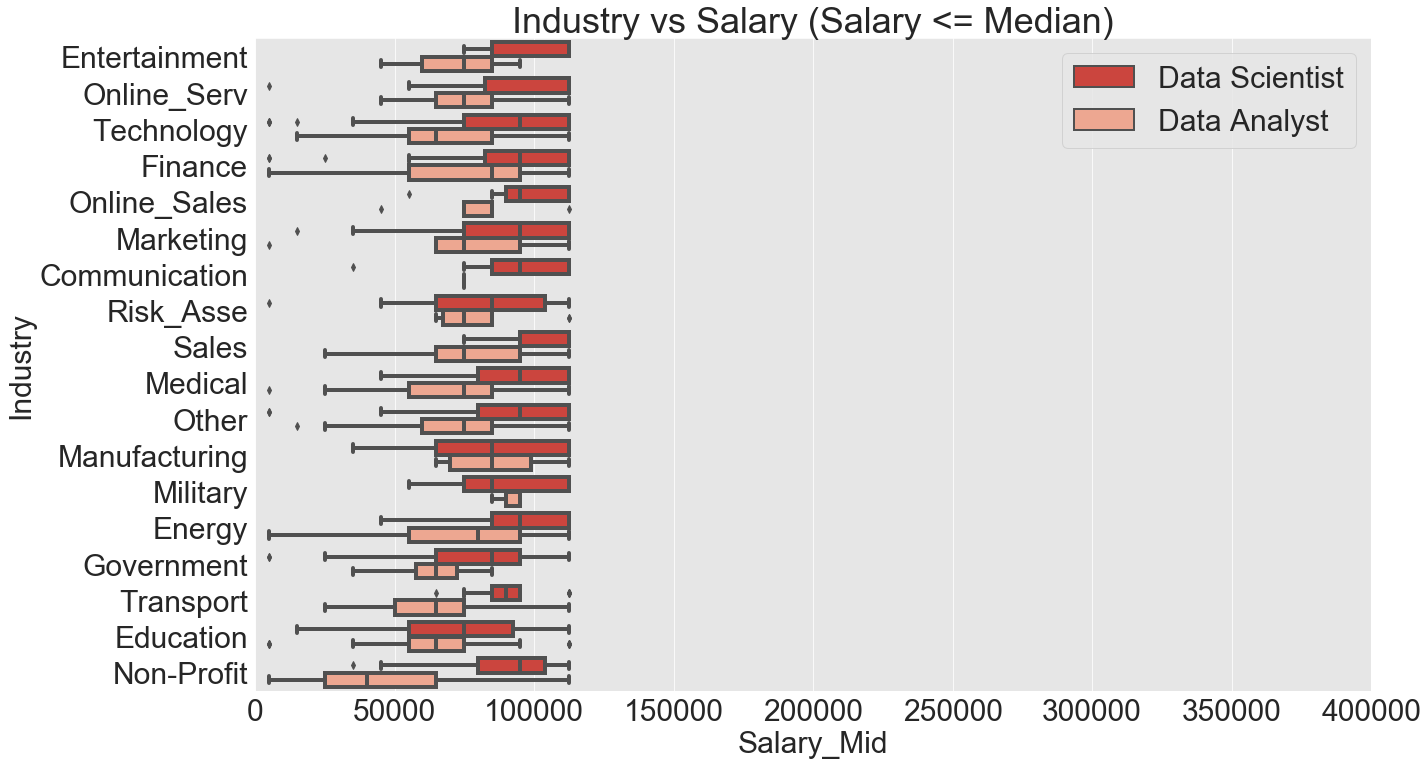

In [17]:
DSA(df, ind_column, ind_order, "Blues_r")
DSA(top_df, ind_column, ind_order, "Greens_r")
DSA(btm_df, ind_column, ind_order, "Reds_r")